In [2]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, LabelEncoder, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

In [3]:

# Load the Titanic dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic = pd.read_csv(url)
titanic.head()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [6]:
titanic.shape

(891, 12)

In [4]:
# Exploring missing values
titanic.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,177
SibSp,0
Parch,0
Ticket,0
Fare,0


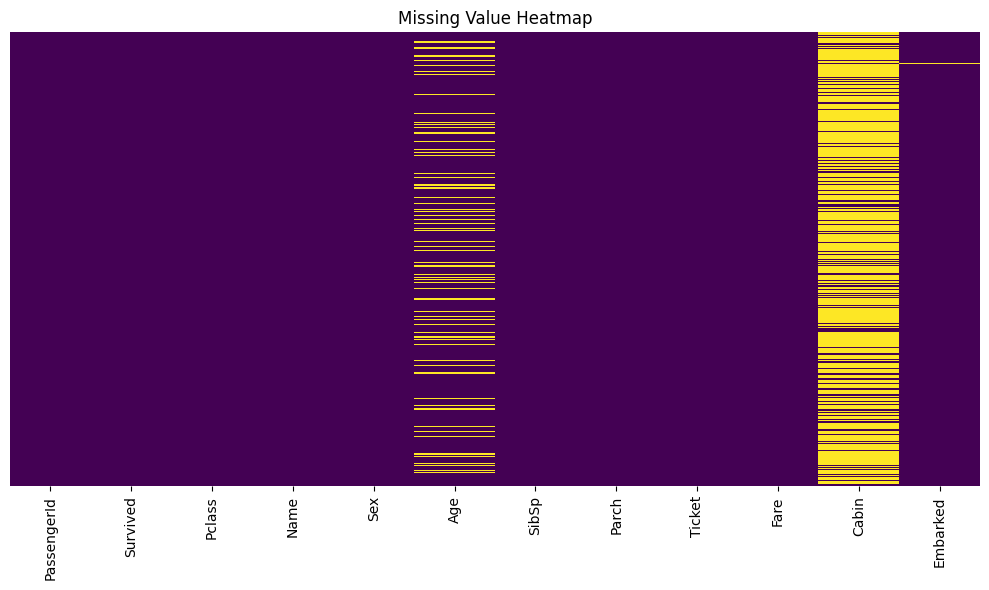

In [7]:
# Visualize missing values
plt.figure(figsize=(10, 6))
sns.heatmap(titanic.isnull(), cbar=False, yticklabels=False, cmap='viridis')
plt.title('Missing Value Heatmap')
plt.tight_layout()
plt.show()

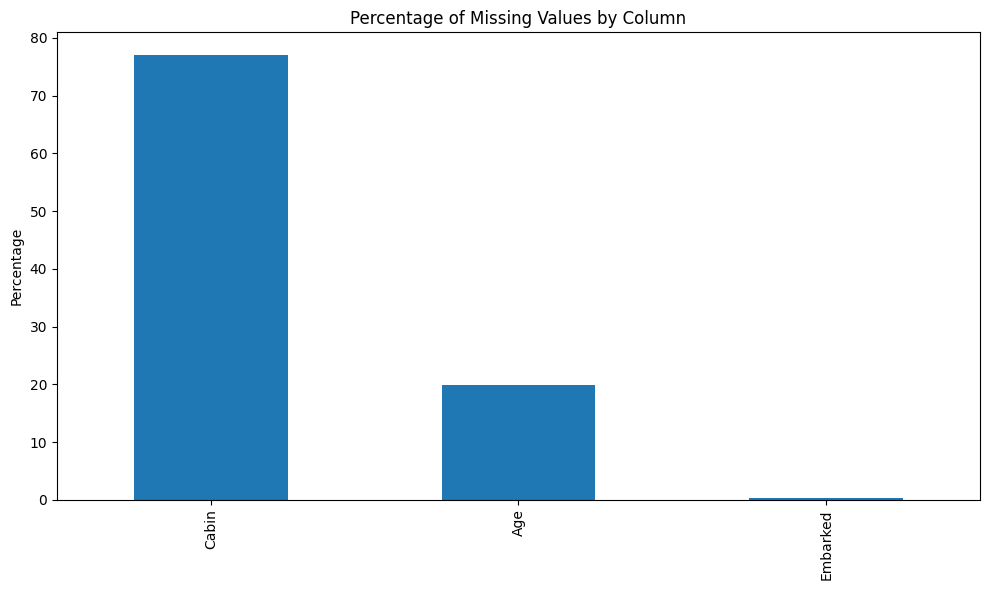

In [8]:
# Calculate percentage of missing values per column
missing_percentage = titanic.isnull().mean() * 100
missing_percentage = missing_percentage[missing_percentage > 0].sort_values(ascending=False)
plt.figure(figsize=(10, 6))
missing_percentage.plot(kind='bar')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('Percentage')
plt.tight_layout()
plt.show()

# HANDLING MISSING VALUES

In [11]:
# 1. Deletion approach - not always recommended but useful for some columns
titanic_reduced = titanic.drop(['Cabin', 'Ticket'], axis=1)  # High missingness or less relevant
titanic_reduced.shape

(891, 10)

In [12]:
# 2. Simple imputation for Age (using median grouped by Pclass)
age_imputed = titanic_reduced.copy()
age_imputed['Age'] = age_imputed.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

In [13]:
# 3. Create missing indicator for Age
age_imputed['Age_Missing'] = titanic_reduced['Age'].isnull().astype(int)

In [14]:
# 4. Mode imputation for categorical column (Embarked)
age_imputed['Embarked'] = age_imputed['Embarked'].fillna(age_imputed['Embarked'].mode()[0])

In [15]:
# Verify imputation results
age_imputed.isnull().sum()

,0
PassengerId,0
Survived,0
Pclass,0
Name,0
Sex,0
Age,0
SibSp,0
Parch,0
Fare,0
Embarked,0


Text(0.5, 1.0, 'Original Age Distribution')

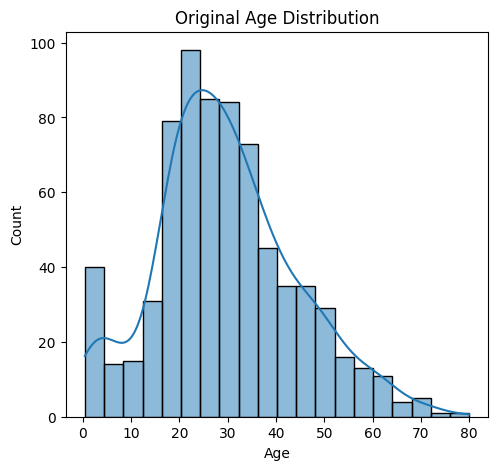

In [16]:
# Visualize Age distribution before and after imputation
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
sns.histplot(titanic['Age'].dropna(), kde=True)
plt.title('Original Age Distribution')

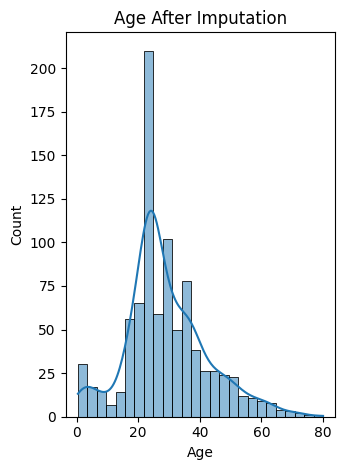

In [17]:
plt.subplot(1, 2, 2)
sns.histplot(age_imputed['Age'], kde=True)
plt.title('Age After Imputation')
plt.tight_layout()
plt.show()

# FEATURE SCALING

In [18]:
# Select relevant columns and prepare a dataset for ML
features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Embarked']
target = 'Survived'
X = age_imputed[features]
y = age_imputed[target]

In [20]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [22]:
# 1. Standardization (z-score normalization)
scaler = StandardScaler()
# Never directly transform your entire dataset - only fit on training data
numeric_features = ['Age', 'Fare']
X_train_std = X_train.copy()
X_test_std = X_test.copy()

X_train_std[numeric_features] = scaler.fit_transform(X_train[numeric_features])
X_test_std[numeric_features] = scaler.transform(X_test[numeric_features])

In [24]:
# 2. Min-Max Scaling (normalization)
min_max_scaler = MinMaxScaler()
X_train_norm = X_train.copy()
X_test_norm = X_test.copy()

X_train_norm[numeric_features] = min_max_scaler.fit_transform(X_train[numeric_features])
X_test_norm[numeric_features] = min_max_scaler.transform(X_test[numeric_features])

Text(0.5, 1.0, 'Original Fare Distribution')

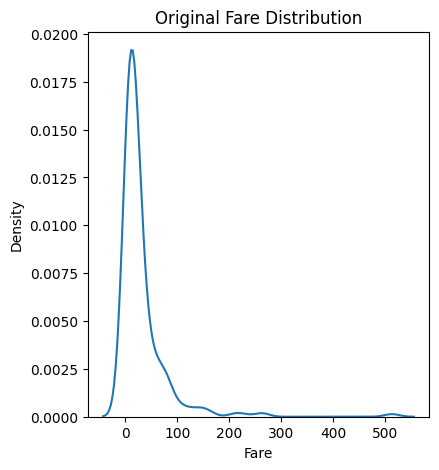

In [25]:
# Visualize scaling effects
plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
sns.kdeplot(X_train['Fare'], label='Original')
plt.title('Original Fare Distribution')

Text(0.5, 1.0, 'Standardized Fare')

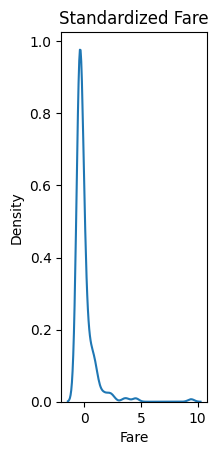

In [26]:
plt.subplot(1, 3, 2)
sns.kdeplot(X_train_std['Fare'], label='Standardized')
plt.title('Standardized Fare')

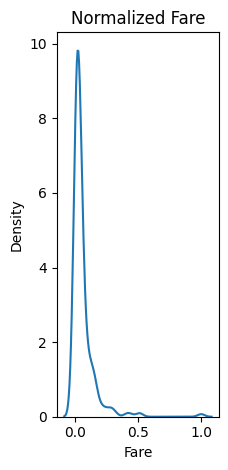

In [27]:
plt.subplot(1, 3, 3)
sns.kdeplot(X_train_norm['Fare'], label='Normalized')
plt.title('Normalized Fare')
plt.tight_layout()
plt.show()

# ENCODING CATEGORICAL VARIABLES

In [30]:
# 1. Label Encoding for ordinal features
label_encoder = LabelEncoder()
X_train_encoded = X_train_std.copy()
X_test_encoded = X_test_std.copy()

In [31]:
# Apply label encoding for Sex column
X_train_encoded['Sex'] = label_encoder.fit_transform(X_train_encoded['Sex'])
X_test_encoded['Sex'] = label_encoder.transform(X_test_encoded['Sex'])

In [32]:
# 2. One-Hot Encoding for nominal features
# Creating a one-hot encoder for 'Embarked'
embarked_ohe = OneHotEncoder(sparse_output=False, drop='first')
# Fit on training data
embarked_train_encoded = embarked_ohe.fit_transform(X_train_encoded[['Embarked']])
embarked_test_encoded = embarked_ohe.transform(X_test_encoded[['Embarked']])

In [33]:
# Create dataframes with the encoded columns
embarked_train_df = pd.DataFrame(
    embarked_train_encoded,
    columns=[f'Embarked_{c}' for c in embarked_ohe.categories_[0][1:]],
    index=X_train_encoded.index
)
embarked_test_df = pd.DataFrame(
    embarked_test_encoded,
    columns=[f'Embarked_{c}' for c in embarked_ohe.categories_[0][1:]],
    index=X_test_encoded.index
)

In [34]:

# Drop original Embarked column and join encoded columns
X_train_encoded = X_train_encoded.drop('Embarked', axis=1).join(embarked_train_df)
X_test_encoded = X_test_encoded.drop('Embarked', axis=1).join(embarked_test_df)


In [35]:
# Compare encoding methods
print("Label Encoded 'Sex':")
print(X_train_encoded['Sex'].value_counts())

Label Encoded 'Sex':
Sex
1    410
0    213
Name: count, dtype: int64


In [36]:
print("\nOne-Hot Encoded 'Embarked':")
print(X_train_encoded.filter(like='Embarked').head())


One-Hot Encoded 'Embarked':
     Embarked_Q  Embarked_S
445         0.0         1.0
650         0.0         1.0
172         0.0         1.0
450         0.0         1.0
314         0.0         1.0


# BUILDING PREPROCESSING PIPELINES

In [37]:
# Define preprocessing for numerical columns
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

In [38]:
# Define preprocessing for categorical columns
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

In [39]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numeric_features),
        ('cat', categorical_transformer, ['Sex', 'Embarked'])
    ])


In [40]:
# Create a full pipeline with preprocessing and model
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression())
])

In [41]:
# Reset to use raw features for complete pipeline demonstration
X = age_imputed[features]
y = age_imputed[target]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [42]:
# Train the pipeline
model_pipeline.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'Fare']),
                                                 ('cat',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['Sex', 'Embarked'])])),
                ('classifier', LogisticRegression())])

In [43]:
# Make predictions
predictions = model_pipeline.predict(X_test)

In [44]:
# Evaluate the model
print(f"Accuracy: {accuracy_score(y_test, predictions):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, predictions))

Accuracy: 0.7799

Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       157
           1       0.75      0.70      0.73       111

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268



# ADVANCED: Custom Pipeline with Cross-Validation

In [45]:
from sklearn.model_selection import GridSearchCV

# Create a pipeline with multiple possible models
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', RandomForestClassifier())
])

In [46]:
# Define parameters to search
param_grid = {
    'classifier__n_estimators': [50, 100],
    'classifier__max_depth': [None, 10],
    'preprocessor__num__imputer__strategy': ['mean', 'median'],
}

In [47]:
# Set up GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5,
                          scoring='accuracy', n_jobs=-1)

In [48]:
# Fit the grid search
grid_search.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(transformers=[('num',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('scaler',
                                                                                          StandardScaler())]),
                                                                         ['Age',
                                                                          'Fare']),
                                                                        ('cat',
                                                                         Pipeline(steps=[('imputer',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('onehot',
                                                                                          OneHotEncoder(drop='first'))]),
                                                                         ['Sex',
                                                                          'Embarked'])])),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__max_depth': [None, 10],
                         'classifier__n_estimators': [50, 100],
                         'preprocessor__num__imputer__strategy': ['mean',
                                                                  'median']},
             scoring='accuracy')

In [49]:
# Best parameters and score
print(f"Best parameters: {grid_search.best_params_}")
print(f"Best cross-validation score: {grid_search.best_score_:.4f}")

Best parameters: {'classifier__max_depth': 10, 'classifier__n_estimators': 100, 'preprocessor__num__imputer__strategy': 'mean'}
Best cross-validation score: 0.7946


In [50]:
# Evaluate on test set
test_score = grid_search.score(X_test, y_test)
print(f"Test set score with best parameters: {test_score:.4f}")

Test set score with best parameters: 0.7575


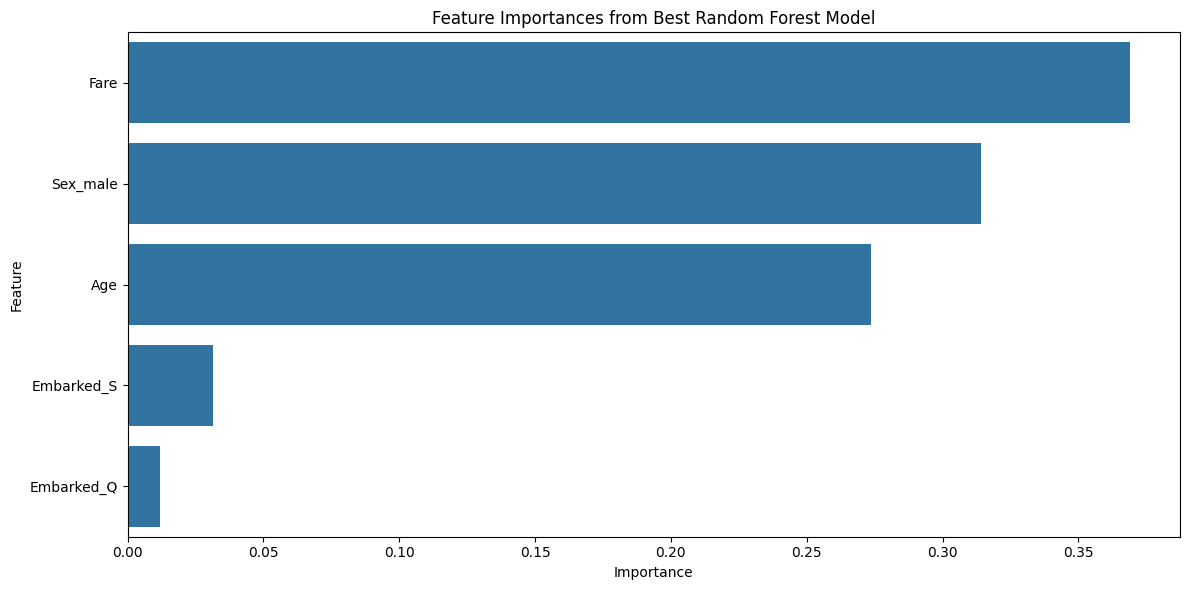

In [51]:
# BONUS: Feature importance from the best model
if hasattr(grid_search.best_estimator_.named_steps['classifier'], 'feature_importances_'):
    # Get the preprocessor
    preprocessor = grid_search.best_estimator_.named_steps['preprocessor']

    # Get the feature names after transformation
    ohe_features = preprocessor.transformers_[1][1].named_steps['onehot'].get_feature_names_out(['Sex', 'Embarked'])
    feature_names = np.concatenate([numeric_features, ohe_features])

    # Get feature importances
    importances = grid_search.best_estimator_.named_steps['classifier'].feature_importances_

    # Create a DataFrame for visualization
    importance_df = pd.DataFrame({
        'Feature': feature_names,
        'Importance': importances
    }).sort_values('Importance', ascending=False)

    # Plot feature importances
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Importance', y='Feature', data=importance_df)
    plt.title('Feature Importances from Best Random Forest Model')
    plt.tight_layout()
    plt.show()

# Excercise

# Week 3 Day 1: Titanic Data Preprocessing & Modeling

In this exercise you'll reinforce:

- **Missing‑value exploration & visualization**  
- **Imputation strategies** (deletion, group‑median, mode, missing indicator)  
- **Feature scaling** (StandardScaler vs MinMaxScaler)  
- **Categorical encoding** (LabelEncoder, OneHotEncoder)  
- **Building end‑to‑end pipelines** with `ColumnTransformer` + `Pipeline`  
- **Model training & evaluation** (LogisticRegression, RandomForest)  
- **Hyperparameter tuning** via `GridSearchCV`  
- **Feature importance** extraction  

> **Instructions:**  
> 1. Don’t modify cells above the first `# TODO`.  
> 2. Replace each `# TODO` with your code.  
> 3. Run cells sequentially and verify each output.  
> 4. Wherever requested, add a brief comment on what you observe.

<Figure size 1000x600 with 0 Axes>

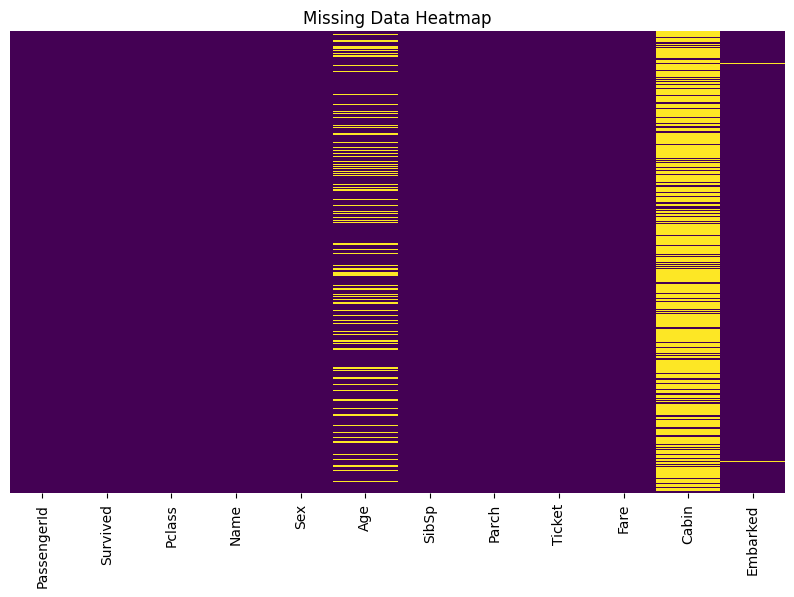

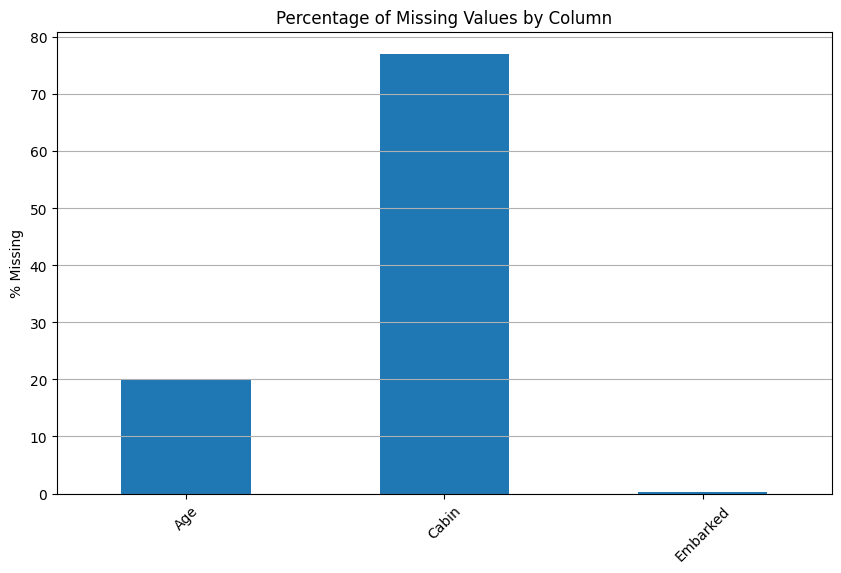

In [53]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1.1 Load dataset
url = "https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv"
titanic = pd.read_csv(url)

# 1.2 How many missing values per column?
# TODO: Compute and display titanic.isnull().sum()
titanic.isnull().sum()

# 1.3 Visualize missingness with a heatmap
plt.figure(figsize=(10,6))
# TODO: use sns.heatmap(...) to show where data is missing
plt.figure(figsize=(10,6))
sns.heatmap(titanic.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Missing Data Heatmap')
plt.show()

# 1.4 Percentage of missing values by column (bar plot)
# TODO: calculate percentage and plot as a bar chart
missing_percent = titanic.isnull().mean() * 100

plt.figure(figsize=(10,6))
missing_percent[missing_percent > 0].plot(kind='bar')
plt.title('Percentage of Missing Values by Column')
plt.ylabel('% Missing')
plt.xticks(rotation=45)
plt.grid(axis='y')
plt.show()


2- Handle Missing Values ---

In [54]:
# Start from a copy
df = titanic.copy()

# 2.1 Drop columns with too many missing or irrelevant
# TODO: df = df.drop([...], axis=1)
# Start from a clean copy
df = df.drop(['Cabin', 'PassengerId', 'Name', 'Ticket'], axis=1)

# 2.2 Impute Age by median within each Pclass
# TODO: df['Age'] = df.groupby('Pclass')['Age'].transform(...)
df['Age'] = df.groupby('Pclass')['Age'].transform(lambda x: x.fillna(x.median()))

# 2.3 Create Age_missing indicator column
# TODO: df['Age_Missing'] = ...
# 2.3 Create Age_missing indicator column
df['Age_Missing'] = df['Age'].isna().astype(int)

# 2.4 Impute Embarked with mode
df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

# 2.5 Verify no more missing values
# TODO: df.isnull().sum()
print(df.isnull().sum())

Survived       0
Pclass         0
Sex            0
Age            0
SibSp          0
Parch          0
Fare           0
Embarked       0
Age_Missing    0
dtype: int64


3. Feature Scaling

<Axes: ylabel='Density'>

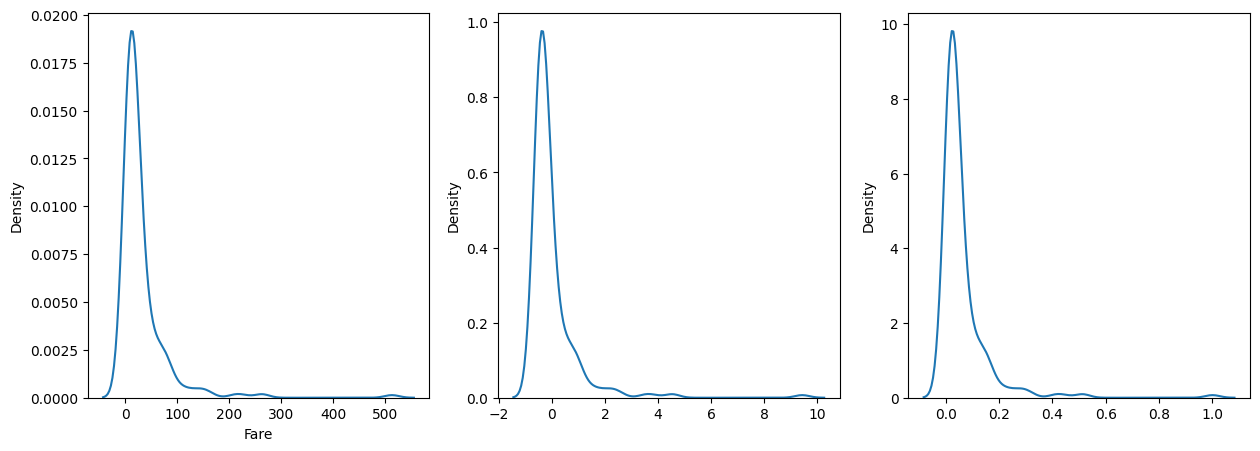

In [56]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

features = ['Age','Fare']
X = df[features]
y = df['Survived']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# 3.1 Standardization
std = StandardScaler()
# TODO: fit on X_train, transform both X_train and X_test
X_train_std = std.fit_transform(X_train)
X_test_std = std.transform(X_test)

# 3.2 Min‑Max normalization
mms = MinMaxScaler()
# TODO: fit on X_train, transform both X_train and X_test
X_train_norm = mms.fit_transform(X_train)
X_test_norm = mms.transform(X_test)

# 3.3 Plot distributions: original vs standardized vs normalized
plt.figure(figsize=(15,5))
# TODO: three subplots with sns.kdeplot for Fare in each dataset
plt.subplot(1,3,1); sns.kdeplot(X_train['Fare'], label='Original')
plt.subplot(1,3,2); sns.kdeplot(X_train_std[:,1], label='Standardized')
plt.subplot(1,3,3); sns.kdeplot(X_train_norm[:,1], label='Normalized')


4. Encode Categorical Features

In [57]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder

X_cat = df[['Sex','Embarked']]

# 4.1 Label‑encode Sex
le = LabelEncoder()
# TODO: X_cat['Sex_le'] = ...
X_cat['Sex_le'] = le.fit_transform(X_cat['Sex'])

# 4.2 One‑hot encode Embarked (drop first)
ohe = OneHotEncoder(sparse_output=False, drop='first')
# TODO: fit_transform Embarked and create a DataFrame with new columns
embarked_encoded = ohe.fit_transform(X_cat[['Embarked']])
embarked_cols = ohe.get_feature_names_out(['Embarked'])
X_cat[embarked_cols] = embarked_encoded

# Display your encoded features
# TODO: print head of resulting DataFrame
print(X_cat.head())


      Sex Embarked  Sex_le  Embarked_Q  Embarked_S
0    male        S       1         0.0         1.0
1  female        C       0         0.0         0.0
2  female        S       0         0.0         1.0
3  female        S       0         0.0         1.0
4    male        S       1         0.0         1.0


<ipython-input-57-8366543f3496>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat['Sex_le'] = le.fit_transform(X_cat['Sex'])
<ipython-input-57-8366543f3496>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_cat[embarked_cols] = embarked_encoded
<ipython-input-57-8366543f3496>:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs

5. Build a Preprocessing + Model Pipeline



In [58]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report

# 5.1 Define transformers
num_features = ['Age','Fare']
cat_features = ['Sex','Embarked']

num_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

cat_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(drop='first'))
])

preprocessor = ColumnTransformer([
    ('num', num_transformer, num_features),
    ('cat', cat_transformer, cat_features)
])

# 5.2 Create full pipeline with Logistic Regression
pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', LogisticRegression(max_iter=1000))
])

# 5.3 Split raw data and train
X_full = df[num_features + cat_features]
y_full = df['Survived']
X_tr, X_te, y_tr, y_te = train_test_split(X_full, y_full, test_size=0.3, random_state=42)

# TODO: fit pipe on X_tr, y_tr
# TODO: predict on X_te, compute accuracy and print classification_report
# 5.3 Fit pipeline and evaluate
pipe.fit(X_tr, y_tr)  # Train the entire pipeline (preprocessing + model)
y_pred = pipe.predict(X_te)  # Generate predictions on test set

# Calculate metrics
accuracy = accuracy_score(y_te, y_pred)
report = classification_report(y_te, y_pred)

# Print results
print(f"Model Accuracy: {accuracy:.3f}")
print("\nDetailed Classification Report:")
print(report)

# Optional: Show confusion matrix
print("\nConfusion Matrix:")
print(pd.crosstab(y_te, y_pred,
                 rownames=['Actual'],
                 colnames=['Predicted']))


Model Accuracy: 0.780

Detailed Classification Report:
              precision    recall  f1-score   support

           0       0.80      0.83      0.82       157
           1       0.75      0.70      0.73       111

    accuracy                           0.78       268
   macro avg       0.77      0.77      0.77       268
weighted avg       0.78      0.78      0.78       268


Confusion Matrix:
Predicted    0   1
Actual            
0          131  26
1           33  78


6. Hyperparameter Tuning with GridSearchCV

Best Parameters: {'clf__max_depth': 10, 'clf__n_estimators': 100, 'preproc__num__imputer__strategy': 'mean'}
Best CV Accuracy: 0.796

Test Set Accuracy: 0.750


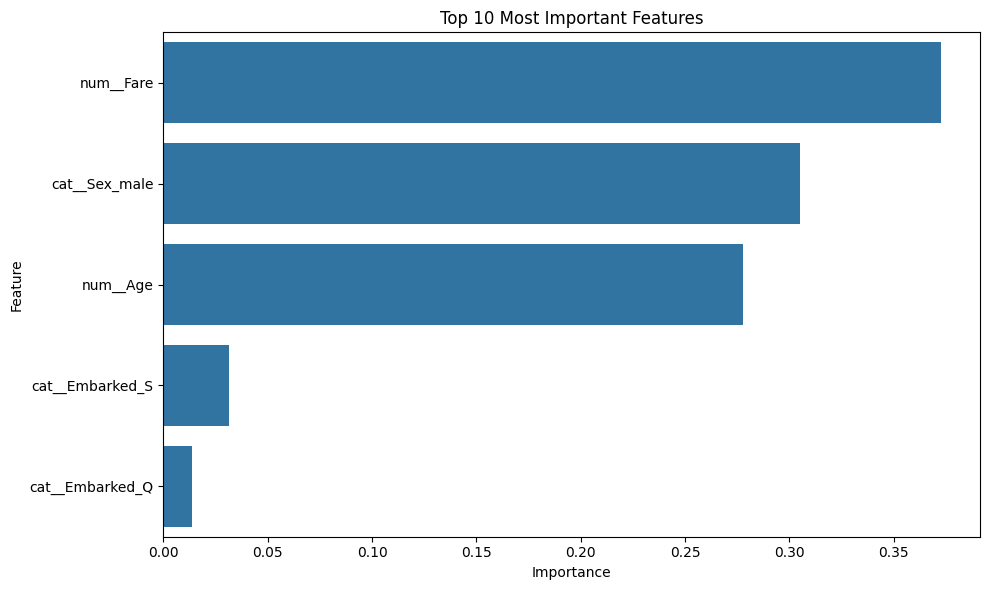

In [59]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# 6.1 Replace classifier in pipeline
tune_pipe = Pipeline([
    ('preproc', preprocessor),
    ('clf', RandomForestClassifier(random_state=42))
])

# 6.2 Set up parameter grid
param_grid = {
    'clf__n_estimators': [50, 100],
    'clf__max_depth': [None, 10],
    'preproc__num__imputer__strategy': ['mean','median']
}

grid = GridSearchCV(tune_pipe, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# 6.2 Fit GridSearchCV
grid.fit(X_tr, y_tr)

# Print best parameters and score
print("Best Parameters:", grid.best_params_)
print(f"Best CV Accuracy: {grid.best_score_:.3f}")

# 6.3 Evaluate on test set
test_score = grid.best_estimator_.score(X_te, y_te)
print(f"\nTest Set Accuracy: {test_score:.3f}")

# 6.4 Bonus - Feature Importances
# Get feature names after preprocessing
preprocessor = grid.best_estimator_.named_steps['preproc']
feature_names = preprocessor.get_feature_names_out()

# Get importances from the best RandomForest
importances = grid.best_estimator_.named_steps['clf'].feature_importances_

# Create and plot DataFrame of top 10 features
top_features = pd.DataFrame({
    'Feature': feature_names,
    'Importance': importances
}).sort_values('Importance', ascending=False).head(10)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=top_features)
plt.title('Top 10 Most Important Features')
plt.tight_layout()
plt.show()
